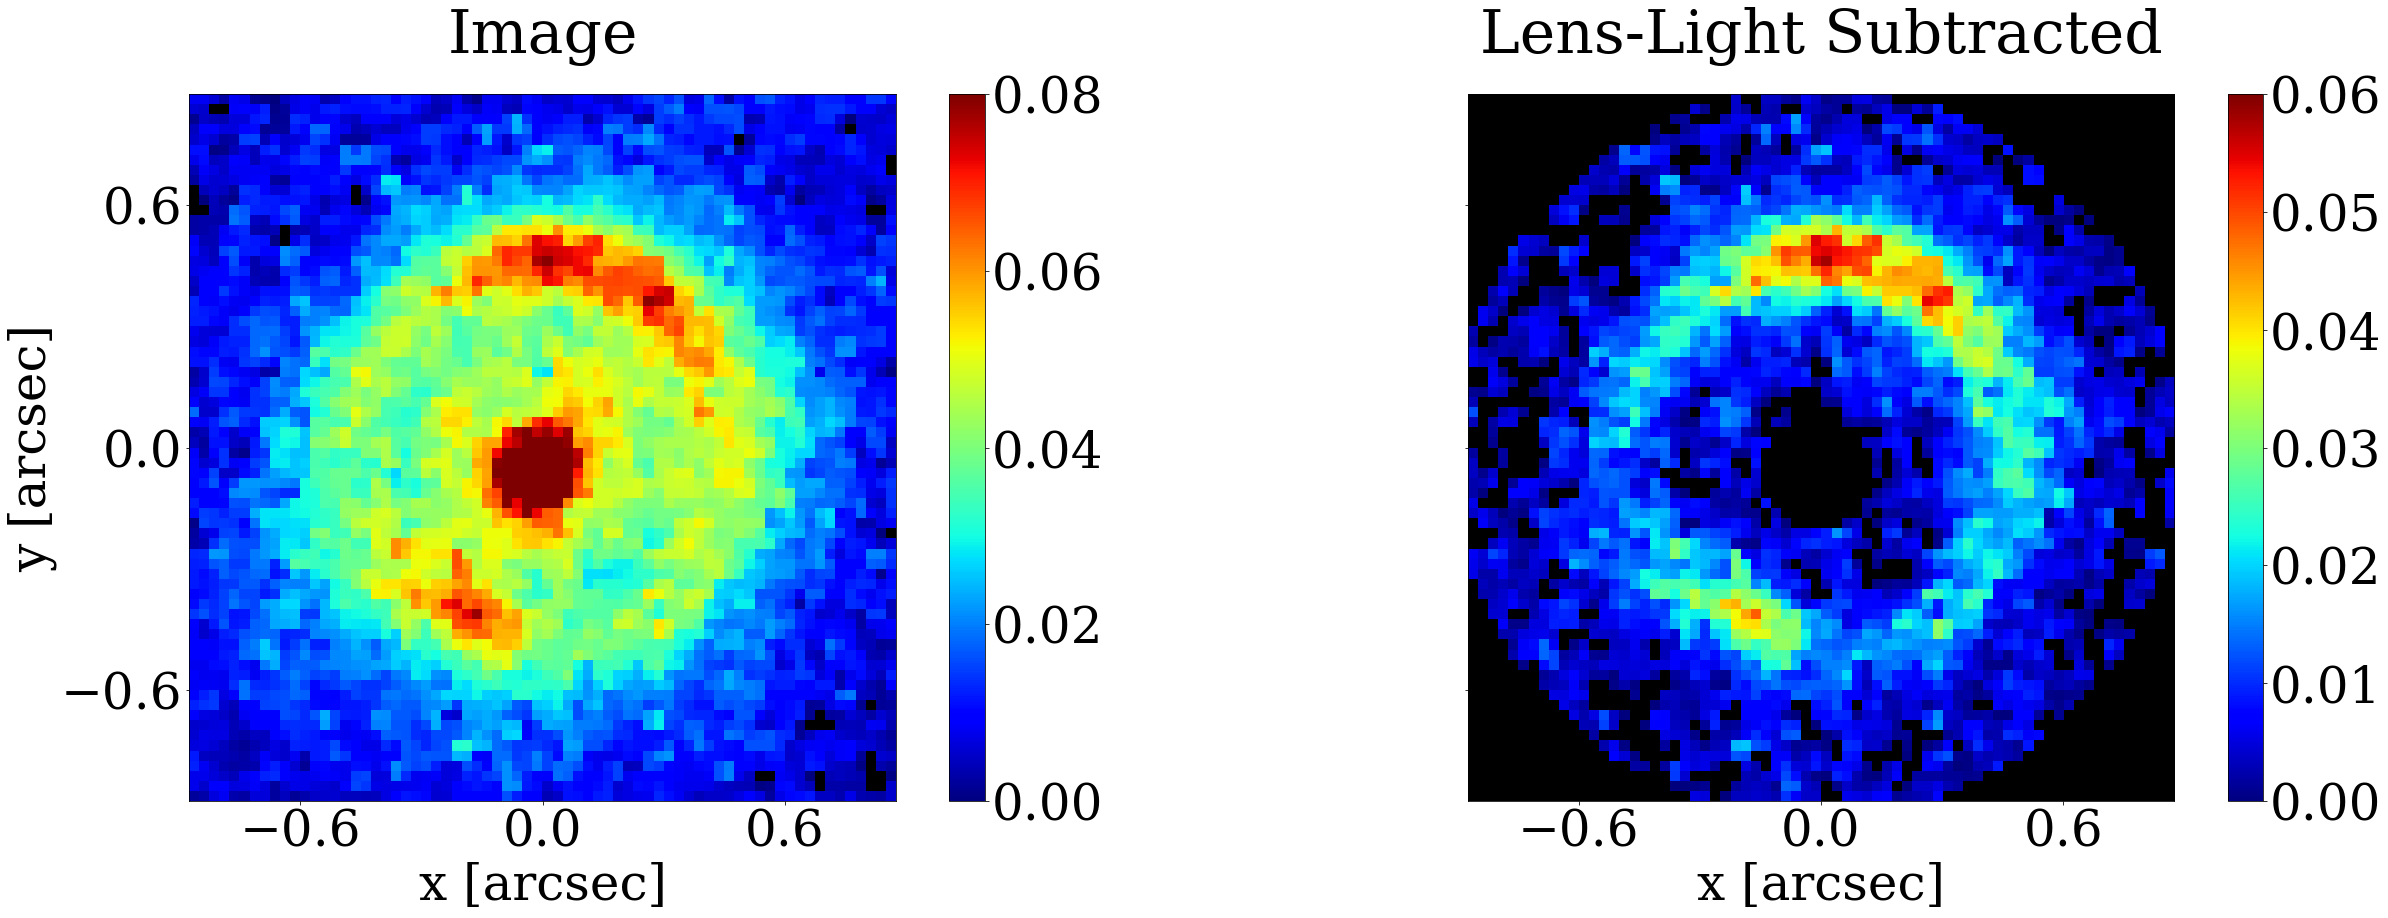

In [2]:
import os
import time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import matplotlib.ticker as tck
from matplotlib import colors

import numpy as np

from scipy.interpolate import interp1d

import lenstronomy.Util.util as util
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.constants as const

from astropy.cosmology import default_cosmology
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from astropy.io import fits
from astropy import constants as const
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.Data.psf import PSF
from lenstronomy.Data.imaging_data import ImageData
from astropy.constants import G, c, M_sun
import astropy.io.fits as pyfits
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Util import kernel_util
import emcee
import corner

mpi = False  # MPI possible, but not supported through that notebook.

from lenstronomy.Workflow.fitting_sequence import FittingSequence
import pyswarms as ps
from lenstronomy.LightModel.Profiles.shapelets import ShapeletSet
import warnings

warnings.filterwarnings('ignore')

import astropy.io.fits as pyfits
from astropy.io import fits
import matplotlib

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 50}
matplotlib.rc('font', **font)
warnings.filterwarnings('ignore')



filename814 = 'HST_7255_07_NIC_NIC1_F160W_drz.fits'
imagedata = np.load('sersic_source_subtracted.npy')

hdul814 = fits.open(filename814)


array814sci = hdul814[1].data
array814wht = hdul814[2].data
array814err = 1/np.sqrt(array814wht)

X = 252
Y = 193
M = 35

array814zoom = np.array(array814sci[int(Y-M):int(Y+M),int(X-M):int(X+M)])

X2 = 130 #180
Y2 = 290 #90
M2 = 35 #35

array814empty = np.array(array814sci[int(Y2-M2):int(Y2+M2),int(X2-M2):int(X2+M2)])

likemask = np.ones([70,70])

for i in range(70):
    for j in range(70):
        if (i-32)**2. + (j-34)**2. < 30:
            likemask[i,j] = np.nan
        if (i-34)**2. + (j-34)**2. > 1300:
            likemask[i,j] = np.nan
            
            
cmap_string = 'jet'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

# here we plot full image of the signal and the noise
ext2 = M2*0.025
extent2 = [-ext2,ext2,-ext2,ext2]

f, axes = plt.subplots(1, 2, figsize=(42,13), sharex=False, sharey=True)
ax = axes


im0 = ax[0].matshow(array814zoom, origin='lower', vmin=0., vmax=0.08, cmap=cmap,extent=extent2)
ax[0].autoscale(False)
ax[0].set_title('Image')
ax[0].xaxis.set_ticks_position('bottom')
ax[0].xaxis.set_major_locator(plt.MaxNLocator(3))
ax[0].yaxis.set_major_locator(plt.MaxNLocator(3))
ax[0].set_xlabel('x [arcsec]')
ax[0].set_ylabel('y [arcsec]')
f.colorbar(im0, ax=axes[0])

im1 = ax[1].matshow(imagedata*likemask, origin='lower', vmin=0., vmax=0.06, cmap=cmap,extent=extent2)
ax[1].autoscale(False)
ax[1].set_title('Lens-Light Subtracted')
ax[1].xaxis.set_ticks_position('bottom')
ax[1].xaxis.set_major_locator(plt.MaxNLocator(3))
ax[1].yaxis.set_major_locator(plt.MaxNLocator(3))
ax[1].set_xlabel('x [arcsec]')
f.colorbar(im1, ax=axes[1])